In [1]:
import pandas as pd
from sklearn.metrics import f1_score


In [2]:
data_df = pd.read_csv('/home/roland/Projects/JP_citation_classification/feature_scraping/data/enriched_data/6_diff_in_publication_date.csv')

In [3]:
data_df = data_df[['citation_context', 'self_citation', 'direct_citations', 'cite_pos_in_sent', 'sent_pos_in_article', 'diff_publication_date', 'citation_class_label']]

In [4]:
data_df = data_df.dropna()

In [5]:
data_df = data_df.reset_index(drop = True)

In [6]:
data_df.self_citation = data_df.self_citation.astype(bool)

# Train-Validation-Test Split

In [7]:
from sklearn.model_selection import train_test_split

# Assuming that your class column is named 'class'
X = data_df.drop('citation_class_label', axis=1)
y = data_df['citation_class_label']

# First split the data into training and a temp set (which will further be divided into validation and test sets)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Split the temp data into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print('Training size:   ', X_train.shape, y_train.shape)
print('Validation size: ', X_val.shape, y_val.shape)
print('Test size:       ', X_test.shape, y_test.shape)


Training size:    (2817, 6) (2817,)
Validation size:  (352, 6) (352,)
Test size:        (353, 6) (353,)


In [21]:
import random
import numpy as np

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(data_df))
val_size = int(0.1 * len(data_df))
test_size = len(data_df) - (train_size + val_size)

# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(data_df))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(data_df))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 2,817
Validation size: 352
      Test size: 353


# XGboost

In [10]:
X_train = X_train.drop('citation_context', axis=1)
X_test = X_test.drop('citation_context', axis=1)
X_val = X_val.drop('citation_context', axis=1)

In [11]:
from xgboost import XGBClassifier

In [15]:
# Create an instance of the classifier
model = XGBClassifier()

# Train it on the training set.
model.fit(X_train, y_train)

# Use the trained model to predict the labels for the test set.
predictions = model.predict(X_test)

# Calculate the F1 score.
f1 = f1_score(y_true = y_test, y_pred = predictions, average='weighted')

print('Using XGBoost on non-text features...')
print('\nF1: %.3f' % f1)

Using XGBoost on non-text features...

F1: 0.495


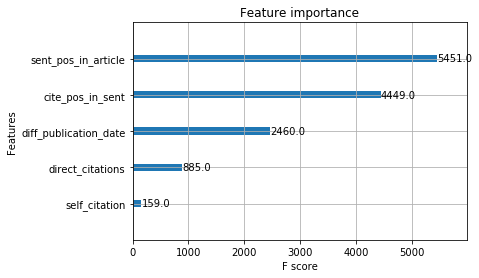

In [16]:
from xgboost import plot_importance
from matplotlib import pyplot

# plot feature importance
plot_importance(model)

pyplot.show()

([0, 1, 2, 3, 4], <a list of 5 Text xticklabel objects>)

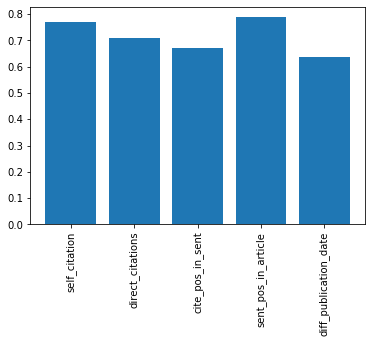

In [17]:
feat_gains = model.get_booster().get_score(importance_type="gain")

pyplot.bar(feat_gains.keys(), feat_gains.values())
pyplot.xticks(rotation = 90)

# BERT just sentence

In [8]:
# This will hold all of the dataset samples, as strings.
sen_w_feats = []

# The labels for the samples.
labels = []

# First, reload the dataset to undo the transformations we applied for XGBoost.

# Some of the reviews are missing either a "Title" or "Review Text", so we'll 
# replace the NaN values with empty string.
data_df = data_df.fillna("")


print('Combining features into strings...')

# For each of the samples...
for index, row in data_df.iterrows():

    # Piece it together...    
    combined = ""
    
    #combined += "The ID of this item is {:}, ".format(row["Clothing ID"])
    combined += "{:}".format(row["citation_context"])
    
    #combined += "I am {:} years old. ".format(row["Age"])
    
    #combined += "I rate this item {:} out of 5 stars. ".format(row["Rating"])
    
    # Not all samples have titles.
    #if not row["Title"] == "":
        #combined += row["Title"] + ". "
    
    # Finally, append the review the text!
    #combined += row["Review Text"]
    
    # Add the combined text to the list.
    sen_w_feats.append(combined)

    # Also record the sample's label.
    labels.append(row["citation_class_label"])

print('  DONE.')

print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))

Combining features into strings...
  DONE.
Dataset contains 3,522 samples.


## Bert with all features

In [74]:
# This will hold all of the dataset samples, as strings.
sen_w_feats = []

# The labels for the samples.
labels = []

# First, reload the dataset to undo the transformations we applied for XGBoost.

# Some of the reviews are missing either a "Title" or "Review Text", so we'll 
# replace the NaN values with empty string.
data_df = data_df.fillna("")


print('Combining features into strings...')

# For each of the samples...
for index, row in data_df.iterrows():

    # Piece it together...    
    combined = ""
    
    #combined += "The ID of this item is {:}, ".format(row["Clothing ID"])
    combined += "{:} ".format(row["citation_context"])
    
    combined += " [SEP] {:}".format(row["self_citation"])
    combined += " [SEP] {:}".format(row["direct_citations"])
    combined += " [SEP] {:}".format(row["cite_pos_in_sent"])
    combined += " [SEP] {:}".format(row["sent_pos_in_article"])
    combined += " [SEP] {:}".format(row["diff_publication_date"])
    
    #combined += "I rate this item {:} out of 5 stars. ".format(row["Rating"])
    
    # Not all samples have titles.
    #if not row["Title"] == "":
        #combined += row["Title"] + ". "
    
    # Finally, append the review the text!
    #combined += row["Review Text"]
    
    # Add the combined text to the list.
    sen_w_feats.append(combined)

    # Also record the sample's label.
    labels.append(row["citation_class_label"])

print('  DONE.')

print('Dataset contains {:,} samples.'.format(len(sen_w_feats)))

Combining features into strings...
  DONE.
Dataset contains 3,522 samples.


In [9]:
import textwrap

# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80) 

print(wrapper.fill(sen_w_feats[1]))

It can be considered as the first map of the Viennese riverscape, which is
depicted in a geographically largely correct manner (Mohilla and Michlmayr 1996;
#CITATION_TAG).


In [10]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 4 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


In [11]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/home/roland/Projects/JP_citation_classification/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading BERT tokenizer...


In [12]:
from transformers import BertForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 6, # The number of output labels--2 for binary classification.
)

# Tell pytorch to run this model on the GPU.
desc = model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [13]:
# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32

# I used a smaller learning rate to combat over-fitting that I was seeing in the
# validation loss. I could probably try even smaller.
learning_rate = 1e-5

# Number of training epochs. 
epochs = 7

In [14]:
max_len = 0

# For every sentence...
for sent in sen_w_feats:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  277


In [15]:
max_len = 277


In [16]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

print('Encoding all reviews in the dataset...')

# For every sentence...
for sent in sen_w_feats:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = max_len,           # Pad & truncate all sentences.
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('DONE.')

Encoding all reviews in the dataset...
DONE.


In [22]:
from torch.utils.data import TensorDataset

# Split the samples, and create TensorDatasets for each split. 
train_dataset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
val_dataset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])
test_dataset = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels[test_idx])

In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [24]:
from transformers import AdamW

# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = learning_rate, 
                  eps = 1e-8 
                )


/home/roland/Projects/JP_citation_classification/venv/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [25]:
from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples!)
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [26]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [27]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [28]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 7 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:19.
  Batch    80  of     89.    Elapsed: 0:00:38.

  Average training loss: 1.41
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.56
  Validation Loss: 1.25
  Validation took: 0:00:02

======== Epoch 2 / 7 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:19.
  Batch    80  of     89.    Elapsed: 0:00:37.

  Average training loss: 1.28
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.18
  Validation took: 0:00:02

======== Epoch 3 / 7 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:19.
  Batch    80  of     89.    Elapsed: 0:00:37.

  Average training loss: 1.18
  Training epcoh took: 0:00:41

Running Validation...
  Accuracy: 0.60
  Validation Loss: 1.15
  Validation took: 0:00:02

======== Epoch 4 / 7 ========
Training...
  Batch    40  of     89.    Elapsed: 0:00:19.
  Batch    80  of     89.    Elapsed: 0:

In [29]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
#df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap (doesn't seem to work in Colab).
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,epoch,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
0,1,1.406619,1.247717,0.562500,0:00:41,0:00:02
1,2,1.280361,1.184725,0.593750,0:00:41,0:00:02
2,3,1.180632,1.151117,0.602273,0:00:41,0:00:02
3,4,1.113043,1.125725,0.596591,0:00:41,0:00:02
4,5,1.045629,1.111266,0.613636,0:00:41,0:00:02
5,6,0.995725,1.103507,0.613636,0:00:41,0:00:02
6,7,0.962710,1.104014,0.613636,0:00:41,0:00:02


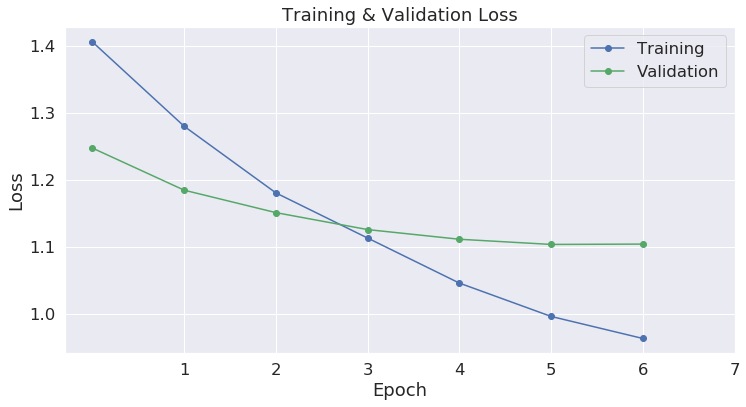

In [30]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5, 6, 7])

plt.show()

In [31]:
# Create a DataLoader to batch our test samples for us. We'll use a sequential
# sampler this time--don't need this to be random!
prediction_sampler = SequentialSampler(test_dataset)
prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 353 test sentences...
    DONE.


In [32]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)


In [33]:
# result no additional features 7 epochs
f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')

print('F1 Score: %.3f' % f1)

F1 Score: 0.489


In [72]:
# result no additional features 15 epochs
f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')

print('F1 Score: %.3f' % f1)

F1 Score: 0.557


In [94]:
# result additional features 7 epochs
f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')

print('F1 Score: %.3f' % f1)

F1 Score: 0.527


# SciBERT